# **Biomarker regions segmentation with 3D U-net**

#### 1. Introduction

In this section we will segment gray matter and subcortical nuclei from preprocessed MRI image.

*Proceeding with this Notebook you confirm your personal acess [to the data](https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release). 
 And your agreement on data [terms and conditions](https://www.humanconnectome.org/study/hcp-young-adult/data-use-terms).*


In [44]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [10]:
!pip install --quiet --upgrade comet_ml python-dotenv
from comet_ml import Experiment

# Load environment variables from a file called `.env` 
# (its contents should be smth like "COMET_API_KEY=<your API key>")

from dotenv import load_dotenv
load_dotenv()

### Variables I used:
# COMET_API_KEY - comet API key
# DATA_DIR - `anat` directory path in my Google Drive


# Create an experiment with your api key
experiment = Experiment(
    project_name="neuroml-hw2",
    workspace="barahlush",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/barahlush/neuroml-hw2/d2c81fff047d476ea7c94ef8c7b15061



### Check the experiments:

**Baseline** - "6 classes, 4 encoding blocks, 8 out, Patch based, 64 batch, crop"
https://www.comet.ml/kondratevakate/mri-segmentation-2021/view/Q6KVHNSRxQ22hC0oM7NL1rF1B

#### 2. Mounting Google drive

Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
data_dir = os.path.join(os.environ.get('DATA_DIR'), 'fs_segmentation')
data_list = os.listdir(data_dir)

#### 3. Defining the dataset

Defining the working dataset, there:

 1. `norm` - normalised `T1` image processed with Freesurfer 6.0,

 2. `aparc+aseg` segmentation mask for gray matter and subcortical nuclei from Freesufer 6.0 `recon all` pipeline.

 And U-net model will treat `norm` image as input and `aparc+aseg` as target model.

In [13]:
import pandas as pd

labels = pd.read_csv(os.path.join(os.environ.get('DATA_DIR'), 'unrestricted_hcp_freesurfer.csv'))

Defining new `pd.Dataframe()` with `Subject`, `norm` and `target` files:

In [21]:
data_list = pd.DataFrame(columns = ['Subject', 'norm', 'aseg'])

In [22]:
data_list['Subject'] = labels['Subject']

Iterating through files and `Subjects` in ID list:

In [23]:
data_list 

,Subject,norm,aseg
0,100206,NaN,NaN
1,100307,NaN,NaN
2,100408,NaN,NaN
3,100610,NaN,NaN
4,101006,NaN,NaN
...,...,...,...
1108,992774,NaN,NaN
1109,993675,NaN,NaN
1110,994273,NaN,NaN
1111,995174,NaN,NaN


In [24]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


for i in tqdm(os.listdir(data_dir)):
    for j in range(0, len(data_list['Subject'])):

        if str(data_list['Subject'].iloc[j]) in i:
            if 'norm' in i: # copydaing path to the column norm
                data_list['norm'].iloc[j] = data_dir +'/'+ i
            elif 'aseg' in i: # copying path to second column
                data_list['aseg'].iloc[j] = data_dir +'/'+ i

data_list.dropna(inplace=True)

100%|██████████| 854/854 [00:11<00:00, 74.02it/s]


In [25]:
data_list.head()

,Subject,norm,aseg
4,101006,/content/drive/MyDrive/data/seminars/anat/fs_s...,/content/drive/MyDrive/data/seminars/anat/fs_s...
5,101107,/content/drive/MyDrive/data/seminars/anat/fs_s...,/content/drive/MyDrive/data/seminars/anat/fs_s...
6,101309,/content/drive/MyDrive/data/seminars/anat/fs_s...,/content/drive/MyDrive/data/seminars/anat/fs_s...
7,101410,/content/drive/MyDrive/data/seminars/anat/fs_s...,/content/drive/MyDrive/data/seminars/anat/fs_s...
8,101915,/content/drive/MyDrive/data/seminars/anat/fs_s...,/content/drive/MyDrive/data/seminars/anat/fs_s...


Let's have a closer look on the data:

     |████████████████████████████████| 10.0 MB 5.4 MB/s eta 0:00:01


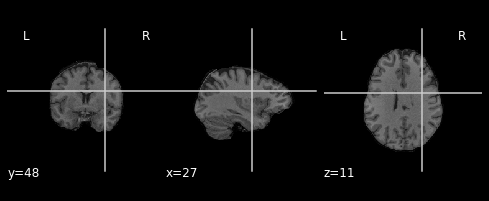

In [26]:
!pip install --quiet --upgrade nilearn
import nilearn
from nilearn import plotting

# visualising normalised image
img = nilearn.image.load_img(data_list['norm'].iloc[0])
plotting.plot_anat(img)

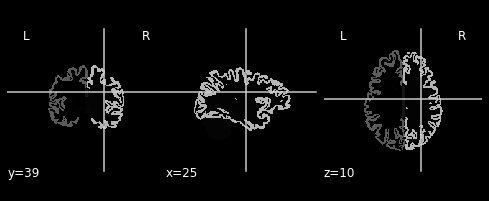

In [27]:
# visualising segmentation
img = nilearn.image.load_img(data_list['aseg'].iloc[0])
plotting.plot_anat(img)

In [28]:
np.unique(np.asanyarray(img.dataobj))

array([   0,    2,    3,    4,    5,    7,    8,   10,   11,   12,   13,
         14,   15,   16,   17,   18,   24,   26,   28,   30,   31,   41,
         42,   43,   44,   46,   47,   49,   50,   51,   52,   53,   54,
         58,   60,   62,   63,   77,   85,  251,  252,  253,  254,  255,
       1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
       1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
       1034, 1035, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035], dtype=int32)

#### Defining a testing dataset

In [29]:
test_subjects = [100206, 100307, 100408]
test_norm_dir = './test'

testing_data_list = pd.DataFrame({
    'Subject': test_subjects,
    'norm': [f'{test_norm_dir}/HCP_T1_fs6_{subject}_norm.nii.gz' for subject in test_subjects],
    'aseg': [f'{test_norm_dir}/HCP_T1_fs6_{subject}_aparc+aseg.nii.gz' for subject in test_subjects]
})


testing_data_list.head()

,Subject,norm,aseg
0,100206,./test/HCP_T1_fs6_100206_norm.nii.gz,./test/HCP_T1_fs6_100206_aparc+aseg.nii.gz
1,100307,./test/HCP_T1_fs6_100307_norm.nii.gz,./test/HCP_T1_fs6_100307_aparc+aseg.nii.gz
2,100408,./test/HCP_T1_fs6_100408_norm.nii.gz,./test/HCP_T1_fs6_100408_aparc+aseg.nii.gz


#### 4. Writing dataloader

We will use `TorchIO` library: https://torchio.readthedocs.io/

In [30]:
!pip install --quiet --upgrade torchio

     |████████████████████████████████| 156 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 48.4 MB 4.5 kB/s eta 0:00:012     |███████████████████████████████▉| 48.2 MB 1.7 MB/s eta 0:00:01


In [33]:
from data_utils import get_torchio_dataset

In [34]:
data, subjects = get_torchio_dataset(data_list['norm'], data_list['aseg'], False)
testing_data, testing_subjects = get_torchio_dataset(testing_data_list['norm'], testing_data_list['aseg'], False)

In [35]:
data[0]['MRI']

Image(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.ByteTensor; memory: 16.0 MiB)

#### 3. Writing visualization tools for torch tensors


In [36]:
from vizualization_utils import *

The class `dataset` inherits from `torch.utils.data.Dataset.` It receives as input a list of torchio.Subject instances and an optional `torchio.transforms.Transform.`

The inputs to the subject class are instances of torchio.Image, such as torchio.ScalarImage or torchio.LabelMap. The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

https://torchio.readthedocs.io/data/dataset.html

In [37]:
from torch.utils.data import DataLoader, Subset
from torchio import AFFINE, DATA, PATH, TYPE, STEM

Dataset size: 427
Image shape: (1, 256, 256, 256)
Segmentation shape: (1, 256, 256, 256)


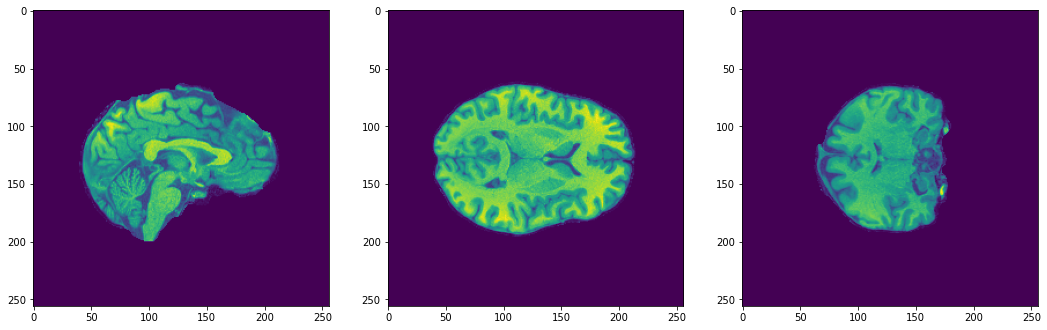

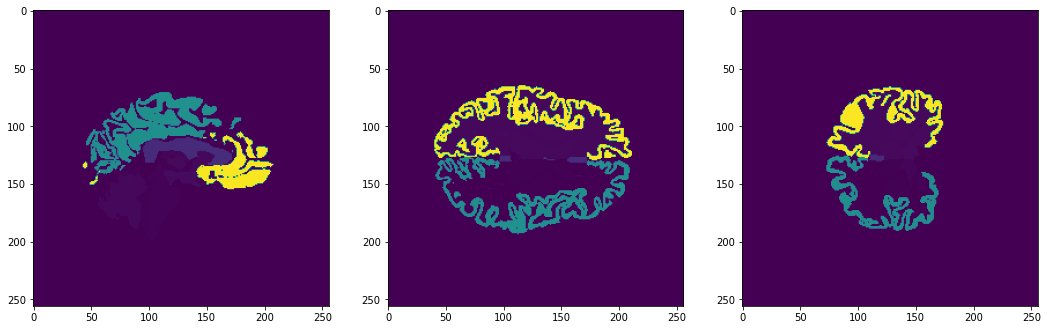

In [38]:
print("Dataset size: {}".format(len(data)))
img = data[0][MRI]
seg = data[0][LABEL]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img[DATA])
plot_central_cuts(seg[DATA])

In [39]:
data[0]['MRI']

Image(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.ByteTensor; memory: 16.0 MiB)

In [40]:
testing_data[0]['MRI']

Image(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.ByteTensor; memory: 16.0 MiB)

Let's choose cropping based on non-zero values of MRI image - maybe all images have padding.

In [46]:
from data_utils import get_crop

[autoreload of data_utils failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


In [52]:

#crop = get_crop(subjects)
crop = (49, 22, 49, 47, 19, 28)
print(crop)

  0%|          | 0/427 [00:00<?, ?it/s]

(49, 22, 49, 47, 19, 28)


## 2. Whole brain segmentation

Let's define the experiment for whole brain segmentation:

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
from torch.utils.data import DataLoader, Subset
import torch.backends.cudnn as cudnn
from torch import optim


import random
import numpy as np
import pandas as pd

import sys
import os
from optparse import OptionParser
import time

import torchio
from torchio import transforms

!pip install --quiet --upgrade unet 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from unet import UNet

from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit

import warnings
import multiprocessing

In [55]:
num_subjects = len(data)

training_split_ratio = 0.9

train_transform = transforms.Compose([
    # several_transforms,
    transforms.Crop(crop),
    transforms.Pad(4)
])

validation_transform = None

training_subjects, validation_subjects = train_test_split(
    subjects, train_size=training_split_ratio, shuffle=True, random_state=42
)

training_subjects = subjects[:20]
validation_subjects = subjects[20:40] # experimenting just on 20 first subjects

training_set = torchio.SubjectsDataset(
    training_subjects, transform=train_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

testing_set = torchio.SubjectsDataset(
    testing_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Testing set:', len(testing_set), 'subjects')

Training set: 20 subjects
Validation set: 20 subjects
Testing set: 3 subjects


In [56]:
CHANNELS_DIMENSION = 6
SPATIAL_DIMENSIONS = 2, 3, 4

VENTRCL =  [4,5,15,43,44,72]# 1
BRN_STEM = [16] # 2
HIPPOCMPS = [17, 53] # 3
AMYGDL = [18, 54] # 4
GM = [1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
       1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035,
       2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035] # 5

LABELS = VENTRCL + BRN_STEM + HIPPOCMPS + AMYGDL + GM # all of interest


def prepare_aseg(targets):
    """
    The function binarises the data  with the LABEL list.
   """
    targets = np.where(np.isin(targets, LABELS, invert = True), 0, targets)
    targets = np.where(np.isin(targets, VENTRCL), 1, targets)
    targets = np.where(np.isin(targets, BRN_STEM), 2, targets)
    targets = np.where(np.isin(targets, HIPPOCMPS), 3, targets)
    targets = np.where(np.isin(targets, AMYGDL), 4, targets)
    targets = np.where(np.isin(targets, GM), 5, targets)


    return targets

def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs = batch[MRI][DATA].to(device)
    targets = batch[LABEL][DATA]
    targets = torch.from_numpy(prepare_aseg(targets))
    targets = targets.to(device)    
    return inputs, targets

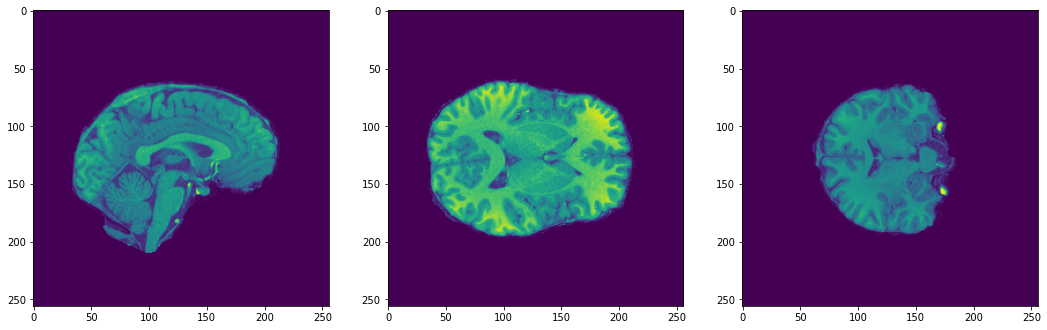

In [57]:
plot_central_cuts(validation_set[1][MRI][DATA])

[0 1 2 3 4 5]


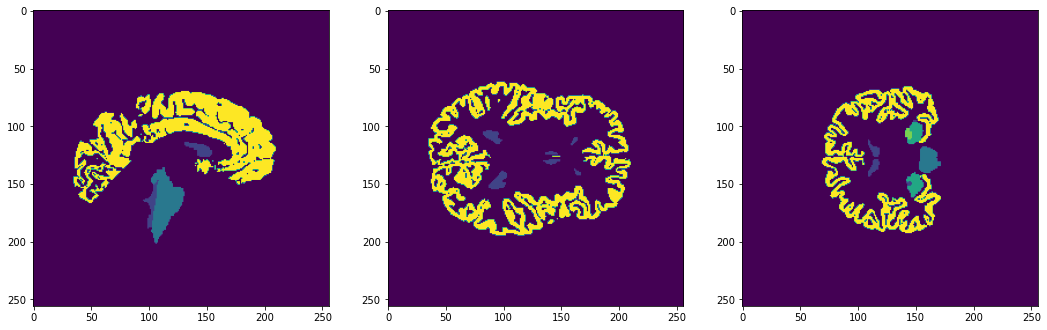

In [58]:
print(np.unique(prepare_aseg(seg[DATA])[0]))

plot_central_cuts(prepare_aseg(validation_set[1][LABEL][DATA][0]))

The data is really heavy, so lets try to start with 1 subject/ batch:

#### Defining the model and optimizer for training

At first check if we have GPU onborad:

In [59]:
torch.cuda.is_available()

True

In [60]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [61]:
class DiceLoss(nn.Module):
    """ Multiclass loss"""
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes, class_wise_dice

In [62]:
def get_model_and_optimizer(device, num_encoding_blocks=4, out_channels_first_layer=8, patience=3):
    #Better to train with num_encoding_blocks >=3, out_channels_first_layer>=4 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    model = UNet(
          in_channels=1,
          out_classes=6,
          dimensions=3,
          num_encoding_blocks=num_encoding_blocks,
          out_channels_first_layer=out_channels_first_layer,
          normalization='batch',
          upsampling_type='linear',
          padding=True,
          activation='PReLU',
      ).to(device)
      
    optimizer = torch.optim.AdamW(model.parameters())
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

# model, optimizer, scheduler = get_model_and_optimizer(device)

## 3. Patch-based segmentation

Let's fedine another experiment within the same workspace in `COMET ML`:

In [63]:
experiment.set_name("6 classes, 4 encoding blocks, 8 out, Patch based, 64 batch, crop")

In [64]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 4
num_training_workers = 8
num_validation_workers = 1

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
#     num_workers=num_training_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
#     num_workers=num_validation_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size, shuffle=False)

In [65]:
import SimpleITK as sitk
from collections import Counter
model_dir = 'checkpoints'
def evaluate(model, evaluation_set, patch_size=64, patch_overlap=0):
    dice_scores = []
    iou_scores = []
    dice_loss = DiceLoss(6)
    
    for i in tqdm(range(len(evaluation_set)), leave=False):
        sample = evaluation_set[i]
        input_tensor = sample[MRI][DATA][0]
        targets = torch.from_numpy(
            prepare_aseg(sample[LABEL][DATA])
        
        )
        
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=validation_batch_size, num_workers=num_validation_workers)

        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=validation_batch_size)
    
        aggregator = torchio.inference.GridAggregator(grid_sampler)
        
        model.eval()
        
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs = patches_batch[MRI][DATA].to(device)
                locations = patches_batch['location']
                logits = model(inputs.float())
        
                aggregator.add_batch(logits, locations)
            
            prediction = aggregator.get_output_tensor()            
            dice_loss_, dice_score_ = dice_loss(prediction.unsqueeze(0), 
                                                targets, 
                                                softmax=True)
            
            dice_scores.append(dice_score_)
            
    return {
        'dice': dice_scores
    }


def train(num_epochs, training_loader, validation_set, model, optimizer, scheduler=None,
          weights_stem='', patch_size=64, patch_overlap=0):
    
    scores = evaluate(model, validation_set, patch_size=patch_size, patch_overlap=patch_overlap)
    
    for key in scores:
        scores[key] = np.mean(scores[key])
        experiment.log_metric(f"avg_val_{key}", scores[key], step=0, epoch=0)
        
    best_dice = scores['dice']
    print(f"Validation mean score: DICE {scores['dice']:0.3f}", "by class:",scores[key] )    
    
    step_counter = Counter()
    torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}.pth'))
    for epoch_idx in range(1, num_epochs + 1):
        print('\nStarting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer, step_counter,
                  scheduler=scheduler)
        
        scores = evaluate(model, validation_set, patch_size=patch_size, patch_overlap=patch_overlap)
        for key in scores:
            scores[key] = np.mean(scores[key])
            experiment.log_metric(f"avg_val_{key}", scores[key], step=epoch_idx, epoch=epoch_idx)
            
        print(f"Validation mean score: DICE {scores['dice']:0.3f}")    
        
        avg_dice = scores['dice']
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), os.path.join(model_dir, f'model_{weights_stem}.pth'))
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer, step_counter, scheduler=None):
    is_training = action == Action.TRAIN
    dice_loss = DiceLoss(6)
    epoch_losses = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader, leave=False)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs.float())
            batch_losses, score_dice = dice_loss(logits, 
                                                 targets.squeeze(1), 
                                                 softmax=True)
            batch_loss = batch_losses.mean() 
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            epoch_losses.append(batch_loss.item())
            if action == Action.TRAIN:
                experiment.log_metric("train_dice_loss", batch_loss.item(),
                                      epoch=epoch_idx, step=step_counter[action])
            elif action == Action.VALIDATE:
                experiment.log_metric("val_dice_loss", batch_loss.item(),
                                      epoch=epoch_idx, step=step_counter[action])
            step_counter[action] += 1
    
    epoch_losses = np.array(epoch_losses)
    avg_loss = epoch_losses.mean()
    
    if action == Action.TRAIN:
        experiment.log_metric("avg_train_dice_loss", avg_loss, step=epoch_idx, epoch=epoch_idx)
        if scheduler:
            scheduler.step(avg_loss)
    
    elif action == Action.VALIDATE:
        experiment.log_metric("avg_val_dice", 1 - avg_loss, step=epoch_idx, epoch=epoch_idx)
    
    print(f'{action.value} mean loss: {avg_loss:0.3f}')
    return avg_loss


In [66]:
torch.cuda.empty_cache()

In [67]:
model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 10
weights_stem = '6_classes_4_blocks_8_chanels'

torch.manual_seed(42)
np.random.seed(42)
    
train(num_epochs, training_loader, validation_set, model, optimizer, scheduler,
      weights_stem=weights_stem, patch_overlap=0)

Validation mean score: DICE 0.086 by class: 0.08600313564141591


NameError: name 'model_dir' is not defined

  0%|          | 0/10 [00:00<?, ?it/s]

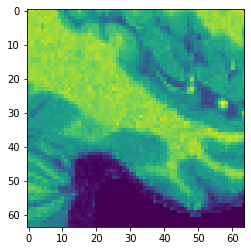

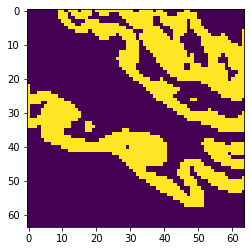

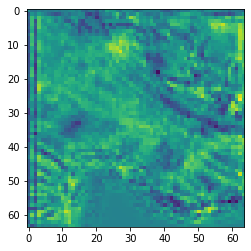

torch.Size([16, 1, 64, 64, 64]) torch.Size([16, 6, 64, 64, 64])
torch.Size([16, 64, 64, 64]) torch.Size([16, 6, 64, 64, 64])


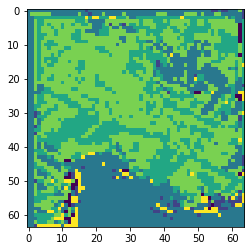

[0.31433534622192383, 0.07340216636657715, 0.04025423526763916, 0.04666447639465332, 0.0254785418510437, 0.2795277237892151]


In [68]:
# checking
enum = enumerate(tqdm(training_loader))
_, batch = next(enum)
inputs, targets = prepare_batch(batch, 'cuda:0')


plt.imshow(inputs.cpu()[2, 0, 32])
plt.show()
plt.imshow(targets.cpu()[2, 0, 32])
plt.show()

labels = model(inputs.float())
plt.imshow(labels.cpu().detach().numpy()[2, 0, 32])
plt.show()

print(targets.size(), labels.size())
dice_loss = DiceLoss(6)

dice_loss_, dice = dice_loss(labels, targets.squeeze(1), softmax=True)
print(targets.squeeze(1).size(), labels.size())

pred = labels.argmax(1,True) #([16, 2, 64, 64, 64])
plt.imshow(pred.cpu().numpy()[2,0, 32])
plt.show()

print(dice)

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_dir, f'model_{weights_stem}.pth'), map_location=device))
test_scores = evaluate(model, testing_set, patch_size=64, patch_overlap=0)
print(test_scores)
print(f"\nTesting mean score: DICE {np.mean(test_scores['dice']):0.3f}")  

In [ ]:
experiment.log_metric("avg_test_dice", np.mean(test_scores['dice']))
for i, subject in enumerate(test_subjects):
    experiment.log_metric(f"test_subj_{subject}_dice", np.mean(test_scores['dice'][i]))

In [ ]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 20
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device)
#         print(inputs.unique())
        locations = patches_batch['location']
        logits = model(inputs.float())
        labels = logits.argmax(dim=1, keepdim=True)
        aggregator.add_batch(labels, locations)
        
plot_central_cuts(aggregator.get_output_tensor())

### Check the experiments with with different clasess, and baseline one:

**Baseline** - "6 classes, 4 encoding blocks, 8 out, Patch based, 64 batch, crop"
https://www.comet.ml/kondratevakate/mri-segmentation-2021/view/Q6KVHNSRxQ22hC0oM7NL1rF1B

### Extra part:
#### If you want to log your images, you may start with that code:

In [ ]:
from einops import rearrange
from torchvision.utils import make_grid

images_grid = []
val_dice = []
model.train(False)
dice_loss = DiceLoss(6)

for batch_idx, batch in enumerate(tqdm(validation_loader)):
    inputs, targets = prepare_batch(batch, device)
    batch_size, _, patch_d = inputs.shape[:3]

    with torch.no_grad():
        logits = model(inputs.float())
        probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
        
        for sample_idx in range(batch_size):
            # appending the predicted and gt picture (central slices)
            pred = 1 - torch.argmax(logits[sample_idx], dim=0)
            
            pred_slice = pred[patch_d // 2]
            gt_slice   = targets[sample_idx, 0, patch_d // 2]
            images_grid.append(make_grid([rearrange(pred_slice.float(), '(c h) w -> c h w',  c=1), 
                                          rearrange(gt_slice.float(), '(c h) w -> c h w', c=1)], 
                                         nrow=1))
            
            dice_loss_, sample_dice = dice_loss(logits,
                                                 targets.squeeze(1), 
                                                 softmax=True)
            
            val_dice.append(sample_dice)            
        
        del inputs, targets, logits, probabilities, sample_dice, pred
        
images_per_pic = 16

for i in range(0, len(images_grid), images_per_pic):
    grid_img = make_grid(images_grid[i:i + images_per_pic])
    grid_img = rearrange(grid_img.cpu().numpy(), 'c h w -> h w c')
    plt.figure(figsize=(20, 20))
    plt.imshow(grid_img)
    plt.show()
    experiment.log_image(grid_img, name='val patches (odd rows -- pred, even rows -- gt)')

Yes, you get a full solution it your hands, yet keep in mind - it is just your baseline. You should experiment with the augmentations, losses and build a story of your model development.